# Pose Estimation using Keypoint RCNN

This notebook will load and use the Keypoint RCNN model, which was trained with a ResNet50 backbone first, before the object detection and pose estimation head was added. This notebook really just seeks to apply and evaluate this model. The main area of interest that the model is tested on is climbing. Many photos of people climbing are run through the model and the results are vizualized and analyzed.

### Load model

Some of the helpful information about this model is from [here](https://learnopencv.com/human-pose-estimation-using-keypoint-rcnn-in-pytorch/), which helps to understand the inputs/outputs.

It is worth noting that this model is capable of estimating the pose of multiple people within the same image. However, we will only ever use images that have one person, as that is the main area of interest.

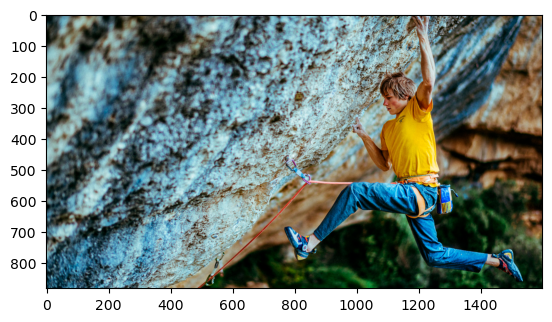

In [21]:
import torchvision
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=torchvision.models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)

filename = 'megos.jpg'
input_image = Image.open(filename)

preprocess = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
arr = np.array(input_image)

# Dealing with two different image formats: [0,1] and [0,255]
# We want normalized for model inputs, but unnormalized for some other functions below.
input_tensor_uint8 = torch.from_numpy(arr)

# %matplotlib inline
plt.imshow(input_tensor.permute(1, 2, 0))


### Object Identification from the Model

We will see more about this model in the following section. In order to recognize a pose, we must first locate a person. This section shows how the model outputs predictions for the bounding boxes of each possible person that was found (as well as the confidence in each of these bounding boxes). Throughout, $N$ will denote the number of people that the model finds within the image. As we will see below, while there is only one person in the above image, $N=4$ for this case. However, only one box has a high confidence level.

{'boxes': tensor([[ 725.4155,   22.6929, 1522.5431,  881.2358],
        [ 966.7560,    0.0000, 1279.4021,  752.7025],
        [ 743.1061,  416.1577, 1553.3090,  854.7836],
        [ 768.8989,  182.9387, 1273.5215,  793.3986]],
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1]), 'scores': tensor([0.9968, 0.2405, 0.1359, 0.1133], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[1.0946e+03, 2.8386e+02, 1.0000e+00],
         [1.1090e+03, 2.6705e+02, 1.0000e+00],
         [1.0922e+03, 2.6945e+02, 1.0000e+00],
         [1.1606e+03, 2.6465e+02, 1.0000e+00],
         [1.0922e+03, 2.7185e+02, 1.0000e+00],
         [1.2074e+03, 3.1388e+02, 1.0000e+00],
         [1.1078e+03, 3.6671e+02, 1.0000e+00],
         [1.2362e+03, 2.1061e+02, 1.0000e+00],
         [1.0934e+03, 4.8318e+02, 1.0000e+00],
         [1.2206e+03, 7.2524e+01, 1.0000e+00],
         [1.0333e+03, 4.0033e+02, 1.0000e+00],
         [1.2218e+03, 5.6484e+02, 1.0000e+00],
         [1.1666e+03, 5.6844e+02, 1.0000e+00],
     

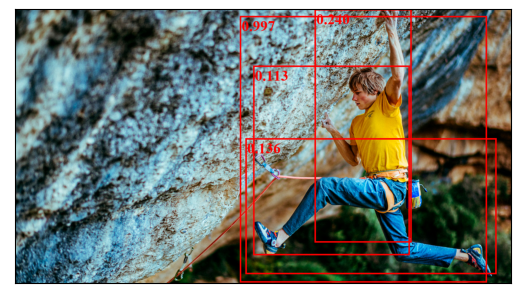

In [3]:
input_batch = input_tensor.unsqueeze(0)
model.eval()
output = model(input_batch)[0]
# Look at what the model outputs. It's a lot.
print(output)

# Draw the boxes.
boxes = output['boxes']
scores = output['scores']
score_lst = [f'{si.item():.3f}' for si in scores]
input_tensor_uint8 = input_tensor_uint8.permute(2,0,1)

# This line of code took longer to figure out than it should have!
drawn_boxes = torchvision.utils.draw_bounding_boxes(input_tensor_uint8,boxes, colors='red', width=5,\
     font='/Windows/Fonts/timesbd.ttf', font_size=48, labels = score_lst)

# From the PyTorch tutorials, a useful helper function for displaying images.
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(drawn_boxes)

### Keypoint Identification from the Model

Keypoints are recorded as $N \times 17 \times 3$. There are $17$ joint locations that the model looks for. Each joint location will have an $(x,y)$ coordinate as well as a visibility mask (the third coordinate). If the joint is visible, the visibility mask is set to $1$. We use the function demonstrated on [Pytorch's Documenation](https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#visualizing-keypoints).

We know there is only one person in the below image, and the model suggests that too, as the other 3 "people" have much lower probabilities. Thus, we will only look at the set of keypoints associated with this person, although we could also look at the keypoints associated with the other "people", if we cared.

torch.Size([4, 17, 3])
tensor([[[1.0946e+03, 2.8386e+02, 1.0000e+00],
         [1.1090e+03, 2.6705e+02, 1.0000e+00],
         [1.0922e+03, 2.6945e+02, 1.0000e+00],
         [1.1606e+03, 2.6465e+02, 1.0000e+00],
         [1.0922e+03, 2.7185e+02, 1.0000e+00],
         [1.2074e+03, 3.1388e+02, 1.0000e+00],
         [1.1078e+03, 3.6671e+02, 1.0000e+00],
         [1.2362e+03, 2.1061e+02, 1.0000e+00],
         [1.0934e+03, 4.8318e+02, 1.0000e+00],
         [1.2206e+03, 7.2524e+01, 1.0000e+00],
         [1.0333e+03, 4.0033e+02, 1.0000e+00],
         [1.2218e+03, 5.6484e+02, 1.0000e+00],
         [1.1666e+03, 5.6844e+02, 1.0000e+00],
         [1.0057e+03, 5.6844e+02, 1.0000e+00],
         [1.2506e+03, 7.7857e+02, 1.0000e+00],
         [8.5327e+02, 7.2934e+02, 1.0000e+00],
         [1.4487e+03, 7.9178e+02, 1.0000e+00]]], grad_fn=<SliceBackward0>)


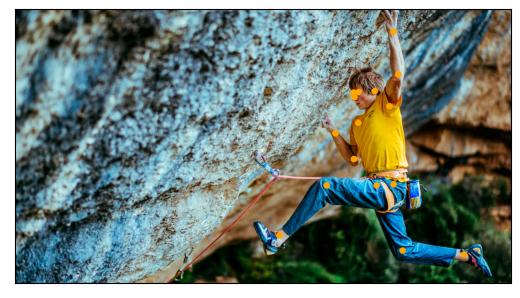

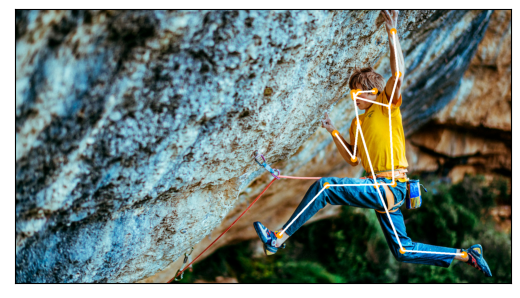

In [4]:
keypoints = output['keypoints']
print(keypoints.shape)
main_keypoints = keypoints[0:1,:,:]
print(main_keypoints)

from torchvision.utils import draw_keypoints

res = draw_keypoints(input_tensor_uint8, main_keypoints, colors="orange", radius=10)

show(res)

# For reference, here are all the keypoints:
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

# And with a skeleton, we need to describe how all of the keypoints are connected
# More on Pytorch.
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

res = draw_keypoints(input_tensor_uint8, main_keypoints, connectivity=connect_skeleton, colors="orange", radius=10, width=7)
show(res)

### Write the above into one function
Input the filename, output the image with the connectivity (and maybe the keypoint locations too)
Assume that there is only one person in the image and that the best set of keypoints will be when this person comes first.

In [5]:
# I want a different connectivity. We will make this while using the setup below to test.
connect_skeleton = [
    (0, 1), (0, 2), (1,3), (2,4), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16),
    (11,12), (5,6)
]

tensor([[[244.3474, 465.0017,   1.0000],
         [215.9670, 451.5050,   1.0000],
         [202.4525, 463.6520,   1.0000],
         [155.1518, 536.5341,   1.0000],
         [156.5033, 539.2335,   1.0000],
         [159.2062, 624.2625,   1.0000],
         [188.9380, 602.6678,   1.0000],
         [325.4343, 396.1685,   1.0000],
         [413.2785, 490.6454,   1.0000],
         [352.4633, 235.5580,   1.0000],
         [440.3074, 316.5381,   1.0000],
         [464.6335, 721.4387,   1.0000],
         [497.0683, 778.1247,   1.0000],
         [479.4995, 536.5341,   1.0000],
         [713.3000, 458.2533,   1.0000],
         [637.6189, 328.6851,   1.0000],
         [630.8617, 342.1818,   1.0000]]], grad_fn=<SliceBackward0>)

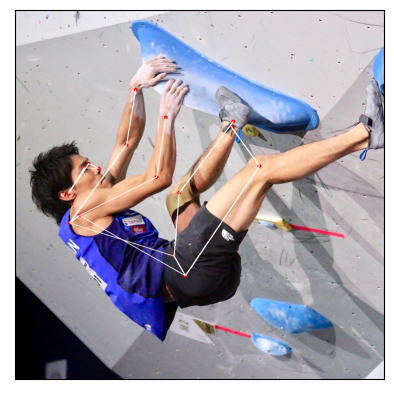

In [6]:
def show_keypoints(filename):
    # Load image
    input_image = Image.open(filename)

    # Tensor formats of image
    input_tensor = preprocess(input_image)
    arr = np.array(input_image)
    input_tensor_uint8 = torch.from_numpy(arr).permute(2,0,1)

    # Run through model and extract keypoints
    output = model(input_tensor.unsqueeze(0))[0]
    keypoints = output['keypoints'][0:1,:,:]

    # Postprocessing
    res = draw_keypoints(input_tensor_uint8, keypoints, connectivity=connect_skeleton, colors="red", radius=5, width=3)
    show(res)
    return keypoints

# Use a different image to debug the function, in case I forget variables or mess up the copy-paste (I did). 

# Use this for another test while writing function.
filename = 'tamoa.jpg'

# Use this for testing new connectivity.
# filename = 'tpose.jpg'
show_keypoints(filename)


Why did the above image not find Tamoa's right foot? The pose itself is a little bit out of the ordinary, and the model likely did not train on much data that was similar to this. We will investigate this hypothesis by trying a different image below. Another possibility is that Tomoa's right foot is too close to the border of the image, so there is not enough context for the model to identify the foot properly. Maybe an image with slighlty more context would have worked.

tensor([[[373.6501, 430.4647,   1.0000],
         [351.6582, 425.4651,   1.0000],
         [343.6612, 455.4626,   1.0000],
         [363.6538, 530.4565,   1.0000],
         [370.6512, 527.4567,   1.0000],
         [438.6259, 576.4527,   1.0000],
         [449.6218, 512.4579,   1.0000],
         [539.5884, 362.4702,   1.0000],
         [539.5884, 364.4701,   1.0000],
         [558.5813, 221.4818,   1.0000],
         [558.5813, 221.4818,   1.0000],
         [385.6456,  61.4950,   1.0000],
         [474.6125,  65.4946,   1.0000],
         [647.5482, 116.4904,   1.0000],
         [636.5522, 289.4762,   1.0000],
         [557.5817, 212.4826,   1.0000],
         [492.6058, 249.4795,   1.0000]]], grad_fn=<SliceBackward0>)

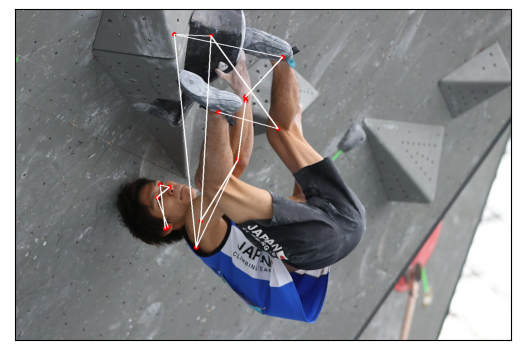

In [7]:
# Test a really unordinary posture
filename = 'tamoa2.jpg'
show_keypoints(filename)

### Test a Bunch of Images

Specifically, I'm interested in applying this to climbers, so I'll run this for more climbing photos. I'll just make a directory and put a bunch of photos in it, then iterate through the directory. I use this [stack overflow answer](https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory) for some small bits of code.

Also note that these images are loaded and evaluated all separately, rather than as one batch. For this scenario, the input images are of different sizes and different resolutions, so we can not create a regular tensor, as the dimensions are not consistent. We could add padding/cropping and upsampling/downsampling, but this is more effort than it is worth. On the other hand, if we are evaluating videos, we would want to use larger batches as inputs.

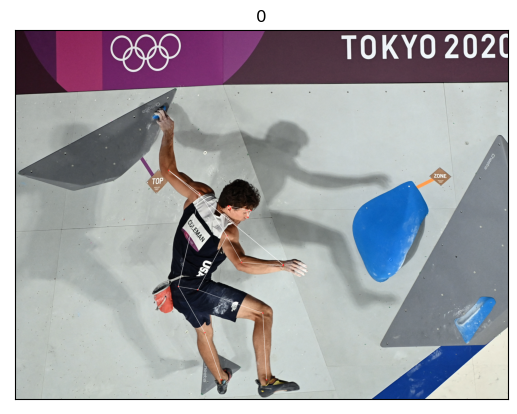

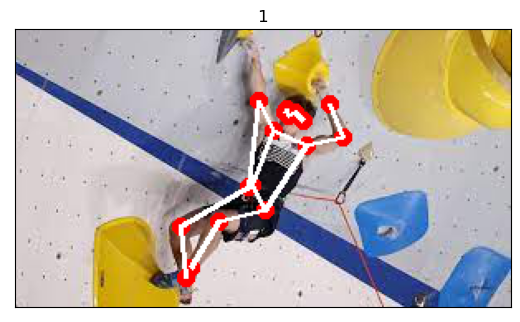

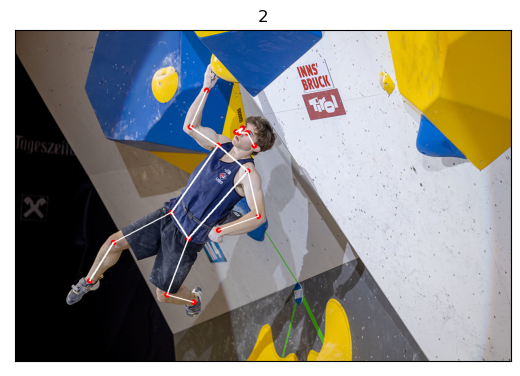

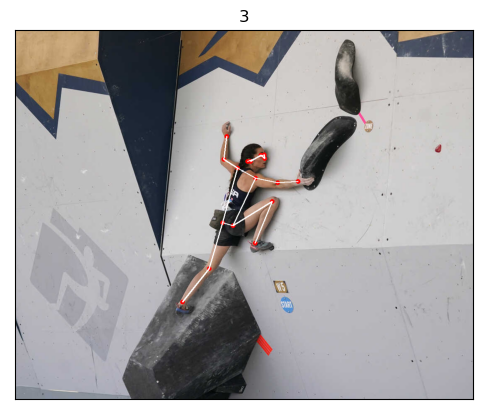

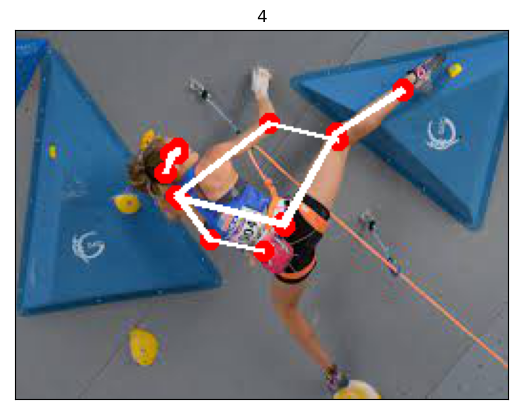

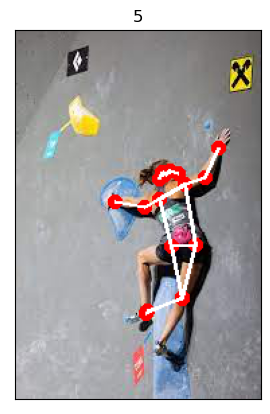

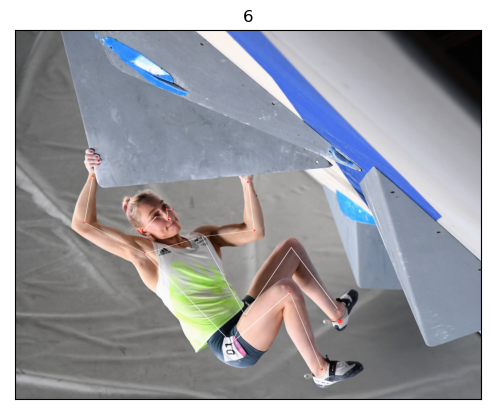

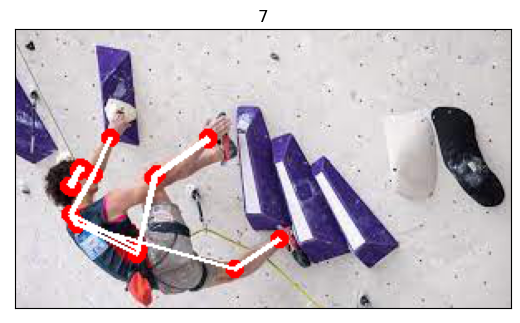

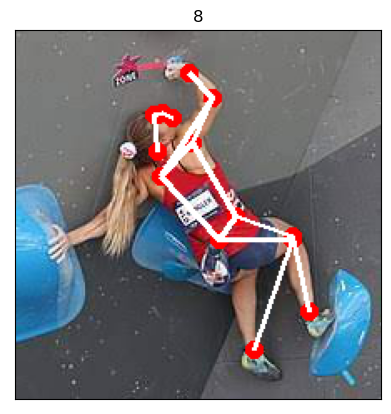

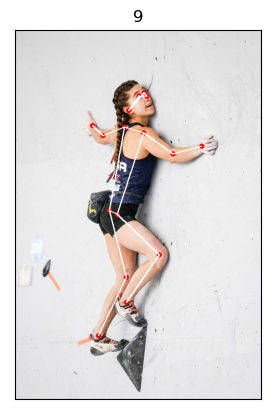

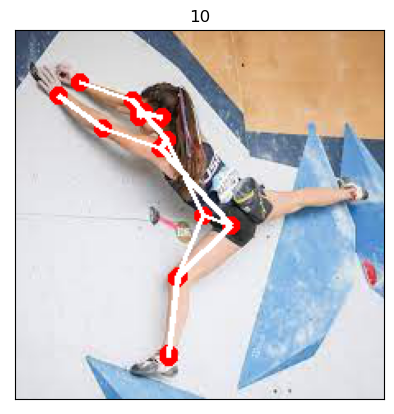

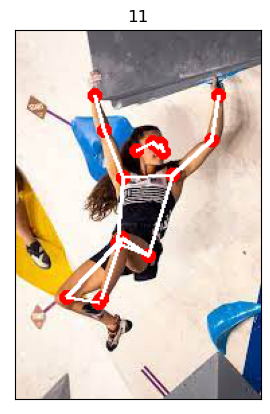

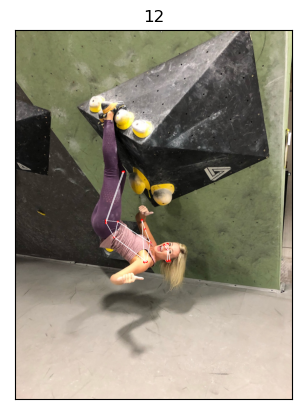

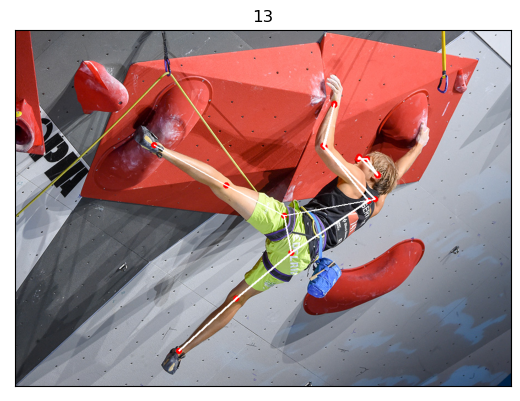

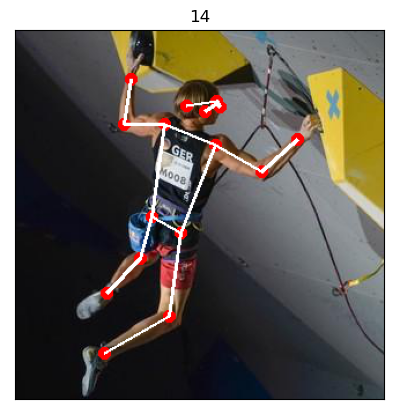

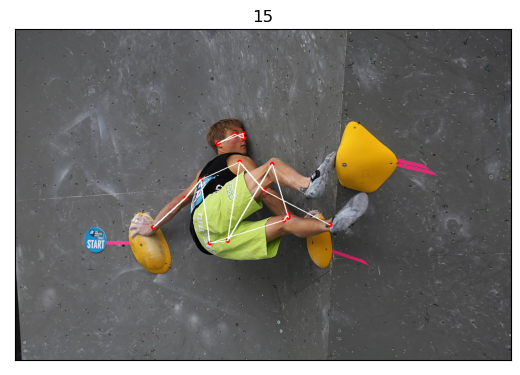

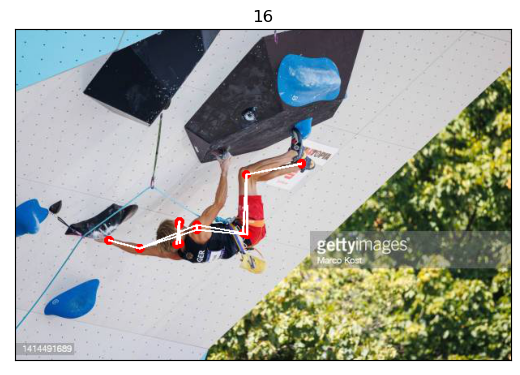

In [8]:
from os import listdir
from os.path import isfile, join

img_dir = 'more_climbers'
filenames = [join(img_dir,f) for f in listdir(img_dir) if isfile(join(img_dir, f))]
n = len(filenames)

for i, filename in enumerate(filenames):
    show_keypoints(filename)
    plt.title(f'{i}')

In the above we see a few things:
* The input images are of different resolutions, which makes our keypoint vizualization vary. However, the model still works for these different input sizes (maybe by preprocessing to one consistent size/resolution). Maybe more attention should be paid to the input image aspect ratios and resolutions.
* The performance is definitely mixed. The model does not perform very good or very bad in a consistent way, it is dependent on the images. It is also somewhat hard to predict or categorize the images that the model performs well on.
  * The model misses some images that I expected to be easy - such as images 0, 5, 8, 10, 13. These images have all the joints visible, with no limbs overlapping.
  * Only images 2, 3, 6, 9, and 14 are accurate. These images are all of high resolution and do not feature odd positions. Joints do not overlap much, and the faces are at least partially visible.
  * On images (4,7) where one important limb is missed (an arm), the rest of the joints also suffer a loss in accuracy. For the rest of the images, the position of the hips is correct or close.
  * Complex or irregular postures are almost always missed (7, 12, 15, 16)
  

### Conclusion

We loaded and experimented with the Keypoint RCNN, evaluating the performance in the specific area of climbing. Overall, the performance was poor, but some of this may be due to other factors that were not fully considered, such as image size and resolution. Future work may use this model on a video, processing multiple frames within one batch. Another idea is to perform distance estimation with a separate model, and to correlate this with hip and shoulder position, for specifics types of climbing and image angles. With the right setup, this could be a useful tool in automated analysis of climbing technique, by distance of the hip position to the wall or other known indicators of technique.

## A quick attempt at a video

I have some time, so I'll try my hand at applying this pose estimation to each frame of a video. Doing this without reusing information wastes some of the continuous structure of the video.

The image is from [here](https://www.youtube.com/watch?v=FOoakoj1POg&t=3s), but screen recorded so I can run things more easily without sampling the hosting url.

In [1]:
import torchvision
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


In [2]:
vid_name = 'short_climb.mp4'

frames_uint8, _, _ = torchvision.io.read_video(vid_name, output_format="TCHW", pts_unit='sec')

print(frames_uint8.shape)

torch.Size([400, 3, 1080, 1920])


tensor(0.)
tensor(1.)
torch.Size([2, 3, 1080, 1080])


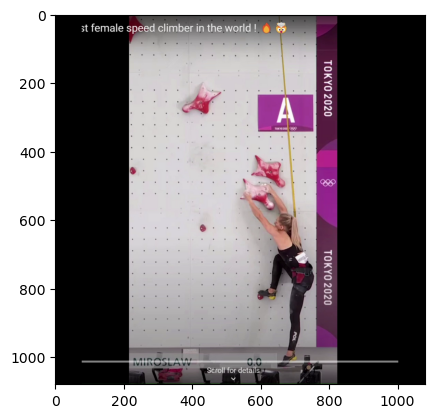

In [3]:

# frames = frames_uint8
# While I'm working on this, only take the start of the video.
N = 2
frames_uint8 = frames_uint8[:N,:,:,:]

img1 = frames_uint8[0,:,:,:]

# Based on the resolution of the video, this will also make the image square
# Quick and dirty conversion to float32
preprocess = transforms.Compose([transforms.CenterCrop(1080), transforms.Lambda(lambda x : x/255.0)])

img1 = preprocess(img1)
plt.imshow(img1.permute(1,2,0))
print(torch.min(img1))
print(torch.max(img1))

# Reuse this var so I don't run out of memory
frames_uint8 = preprocess(frames_uint8)
print(frames_uint8.shape)

In [8]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=torchvision.models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)

model.eval()
output = model(frames_uint8)

[{'boxes': tensor([[ 547.7344,  479.4936,  752.4312, 1013.7173],
        [ 711.0672, 1015.8762,  773.6711, 1079.6111],
        [ 534.4328,  480.8943,  677.0900,  591.7936]],
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9990, 0.0724, 0.0505], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[6.3864e+02, 6.1372e+02, 1.0000e+00],
         [6.4537e+02, 6.0563e+02, 1.0000e+00],
         [6.4672e+02, 6.0293e+02, 1.0000e+00],
         [6.6018e+02, 6.2047e+02, 1.0000e+00],
         [6.8846e+02, 6.1642e+02, 1.0000e+00],
         [6.4806e+02, 6.4205e+02, 1.0000e+00],
         [6.8712e+02, 6.4340e+02, 1.0000e+00],
         [5.9824e+02, 5.9484e+02, 1.0000e+00],
         [6.6826e+02, 5.7325e+02, 1.0000e+00],
         [5.6861e+02, 5.4492e+02, 1.0000e+00],
         [6.3594e+02, 5.2064e+02, 1.0000e+00],
         [7.1809e+02, 7.7291e+02, 1.0000e+00],
         [7.3829e+02, 7.5807e+02, 1.0000e+00],
         [7.0058e+02, 8.7949e+02, 1.0000e+00],
         [6.5076e+02, 

In [ ]:
connect_skeleton = [
    (0, 1), (0, 2), (1,3), (2,4), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16),
    (11,12), (5,6)
]



def show_keypoints_tens(input_tensor):
    # Need to change this function to convert to uint8
    input_tensor_uint8 = torch.from_numpy(arr).permute(2,0,1)

    # Run through model and extract keypoints
    output = model(input_tensor.unsqueeze(0))[0]
    keypoints = output['keypoints'][0:1,:,:]

    # Postprocessing
    res = draw_keypoints(input_tensor_uint8, keypoints, connectivity=connect_skeleton, colors="red", radius=5, width=3)
    show(res)
    return keypoints

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for out in output:
    keypoints = out['keypoints']

    